In [1]:
import os

# Define the paths
base_path = 'data/'
train_path = 'data/train/'
test_path = 'data/test/'

# Create the folders
os.makedirs(train_path + 'vehicles', exist_ok=True)
os.makedirs(train_path + 'non-vehicles', exist_ok=True)
os.makedirs(test_path + 'vehicles', exist_ok=True)
os.makedirs(test_path + 'non-vehicles', exist_ok=True)

In [2]:
import shutil

# Define the source and destination paths
src_vehicles_path = base_path + 'vehicles/'
src_non_vehicles_path = base_path + 'non-vehicles/'

dest_train_vehicles_path = train_path + 'vehicles/'
dest_train_non_vehicles_path = train_path + 'non-vehicles/'
dest_test_vehicles_path = test_path + 'vehicles/'
dest_test_non_vehicles_path = test_path + 'non-vehicles/'

#split the data into 80% for training and 20% for testing
split_ratio = 0.8

# List all vehicle and non-vehicle images
vehicle_images = os.listdir(src_vehicles_path)
non_vehicle_images = os.listdir(src_non_vehicles_path)

# Calculate the number of images for training and testing
num_train_vehicles = int(len(vehicle_images) * split_ratio)
num_train_non_vehicles = int(len(non_vehicle_images) * split_ratio)

# Copy images to the training folders
for img in vehicle_images[:num_train_vehicles]:
    shutil.copy(src_vehicles_path + img, dest_train_vehicles_path + img)


for img in non_vehicle_images[:num_train_non_vehicles]:
    shutil.copy(src_non_vehicles_path + img, dest_train_non_vehicles_path + img)

# Copy the remaining images to the testing folders
for img in vehicle_images[num_train_vehicles:]:
    shutil.copy(src_vehicles_path + img, dest_test_vehicles_path + img)

for img in non_vehicle_images[num_train_non_vehicles:]:
    shutil.copy(src_non_vehicles_path + img, dest_test_non_vehicles_path + img)

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.applications import  MobileNetV2
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras import models, layers

In [4]:
Batch_size1 = 32
# Define data augmentation parameters for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5], 
    channel_shift_range=50 #shifts the color channels 
)
# Create a data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255
)
print(test_datagen)

test_Image = test_datagen.flow_from_directory(
    'data/test',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary',
    shuffle=False  # Important: Set shuffle to False for evaluation
)

train_Image = train_datagen.flow_from_directory(
    'data/train',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary'
)

Found 3553 images belonging to 2 classes.
Found 14207 images belonging to 2 classes.


In [5]:
cnn_model = Sequential()

# Add convolutional layers with max pooling
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='Same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output 
cnn_model.add(Flatten())

# Add dense layers with dropout for regularization to prevent overfitting
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dropout(0.2))
# Output layer with sigmoid activation for binary classification
cnn_model.add(Dense(1, activation="sigmoid"))
#early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
# Compile the model with binary crossentropy loss and Adam optimizer
optimizer = Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(),Recall()])

c:\Users\HP\Desktop\Project\backend\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Train the CNN model
Evaluate1 = cnn_model.fit(train_Image, epochs=10, validation_data=test_Image, batch_size=Batch_size1, callbacks=[early_stopping])

Epoch 1/10


c:\Users\HP\Desktop\Project\backend\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


444/444 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.7791 - loss: 0.4309 - precision: 0.7444 - recall: 0.8981 - val_accuracy: 0.9184 - val_loss: 0.2620 - val_precision: 0.9288 - val_recall: 0.9045
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 174s 386ms/step - accuracy: 0.9463 - loss: 0.1432 - precision: 0.9502 - recall: 0.9403 - val_accuracy: 0.9291 - val_loss: 0.2315 - val_precision: 0.9212 - val_recall: 0.9369
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 150s 336ms/step - accuracy: 0.9642 - loss: 0.0986 - precision: 0.9678 - recall: 0.9597 - val_accuracy: 0.9279 - val_loss: 0.1889 - val_precision: 0.9017 - val_recall: 0.9591
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 173s 384ms/step - accuracy: 0.9739 - loss: 0.0771 - precision: 0.9780 - recall: 0.9690 - val_accuracy: 0.9277 - val_loss: 0.1947 - val_precision: 0.9126 - val_recall: 0.9443
Epoch 4: early stopping


In [7]:
print("\nClassification Report:")
score, acc, pre, rcl = cnn_model.evaluate(test_Image)
print('Test Loss:', score * 100)
print('Test Accuracy:' ,acc * 100)
print('Test Precision:',pre * 100)
print('Test Recall:', rcl * 100)
f1_score=2 * (pre * rcl) / (rcl + rcl)
print('Test F1-Score:' ,f1_score * 100)


Classification Report:
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9249 - loss: 0.1853 - precision: 0.3937 - recall: 0.4813
Test Loss: 19.47484314441681
Test Accuracy: 92.76667833328247
Test Precision: 91.26373529434204
Test Recall: 94.42865252494812
Test F1-Score: 91.26373529434204


112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step


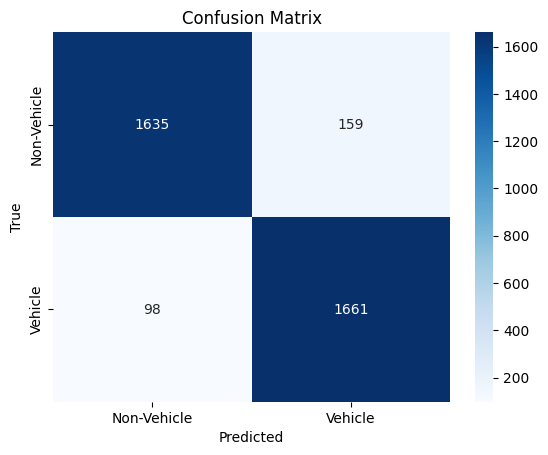

In [8]:
# Generate predictions for the test set using the evaluation generator
predictions = cnn_model.predict(test_Image)

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Get true labels
true_labels = test_Image.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

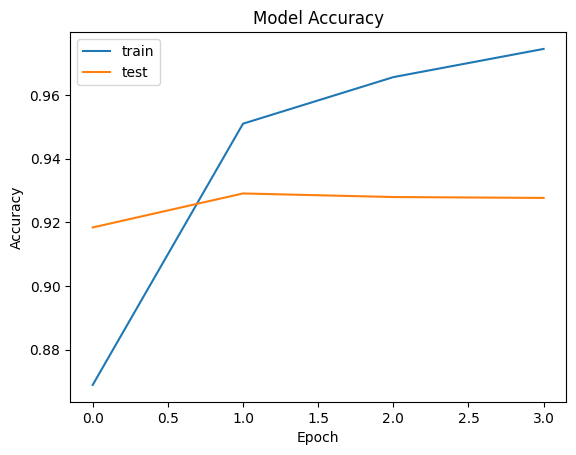

In [9]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in Evaluate1.history :
    k = 'accuracy'

if 'acc' in Evaluate1.history :
    k = 'acc'

if k != '' :
    plt.plot(Evaluate1.history[k])
    plt.plot(Evaluate1.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()





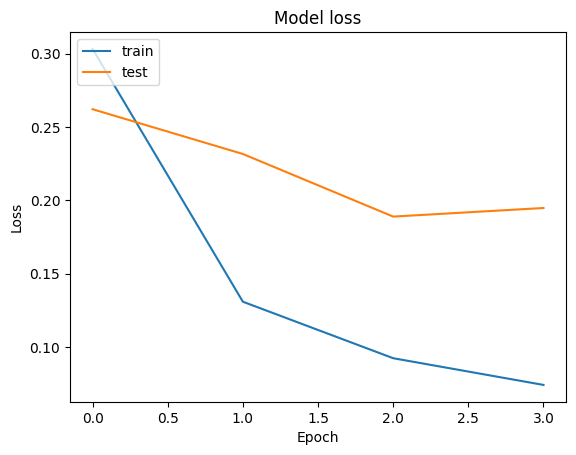

In [10]:
plt.plot(Evaluate1.history['loss'])
plt.plot(Evaluate1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_14700\328043369.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(predicted_prob > 0.5)


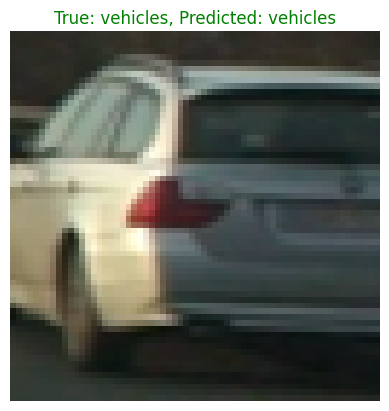

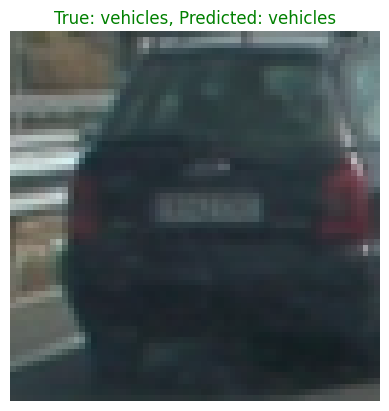

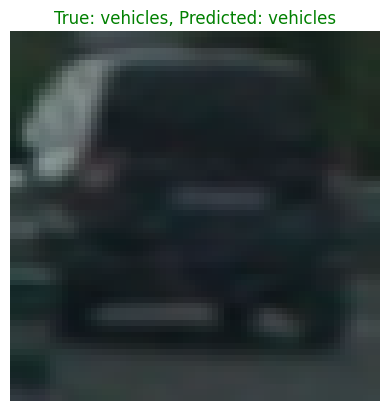

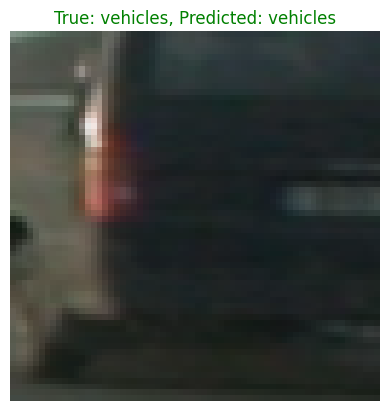

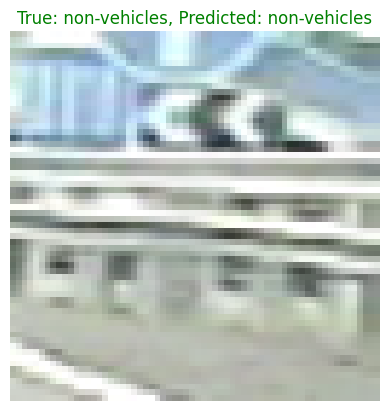

In [38]:
class_labels = {0: 'non-vehicle', 1: 'vehicle'}

# Function to display images with predictions
def visualize_predictions(model, test_data_gen, num_samples=5):

    # Generate predictions for the test set
    predictions = model.predict(test_data_gen)

    # Get the true labels from the test set
    true_labels = test_data_gen.classes

    # Get the class indices (0 or 1)
    class_indices = test_data_gen.class_indices

#     # Get the class labels ('non-vehicle' or 'vehicle')
    class_labels = {v: k for k, v in class_indices.items()}

    filenames = test_data_gen.filenames

    # Select a random sample of test images
    sample_indices = np.random.choice(len(filenames), num_samples, replace=False)

    # Display the images with predictions
    for i in sample_indices:
        filename = filenames[i]

        # Get the true label
        true_label = class_labels[true_labels[i]]

        # Get the predicted probability and class
        predicted_prob = predictions[i]
        predicted_class = int(predicted_prob > 0.5)
        predicted_label = class_labels[predicted_class]

        # Determine the color for the label (green for correct, red for incorrect)
        label_color = 'green' if true_label == predicted_label else 'red'

        # Load and display the image
        img_path = os.path.join('data/test/', filename)
        img = plt.imread(img_path)

        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}', color=label_color)
        plt.axis('off')
        plt.show()

visualize_predictions(cnn_model, test_Image, num_samples=5)


In [36]:
Batch_size2 = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],  # Add brightness adjustment
    channel_shift_range=50  # Add channel shift
)

test_datagen = ImageDataGenerator(rescale=1./255
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     brightness_range=[0.5, 1.5],  # Add brightness adjustment
#     channel_shift_range=50  # Add channel shift
)
test_Image = test_datagen.flow_from_directory(
    'data/test',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary',
    shuffle=False  # Important: Set shuffle to False for evaluation
)

train_Image = train_datagen.flow_from_directory(
    'data/train',
    target_size=(64, 64),
    batch_size=Batch_size1,
    class_mode='binary'
)

Found 3553 images belonging to 2 classes.
Found 14207 images belonging to 2 classes.


In [13]:
base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(1048, activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1048, activation='relu',kernel_regularizer=l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_14700\3511974325.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model= MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [14]:
Evaluate2 = model.fit(train_Image, epochs=10, validation_data=test_Image, batch_size=Batch_size2, callbacks=[early_stopping])

Epoch 1/10


c:\Users\HP\Desktop\Project\backend\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


444/444 ━━━━━━━━━━━━━━━━━━━━ 219s 416ms/step - accuracy: 0.9020 - loss: 23.1433 - precision_1: 0.9225 - recall_1: 0.8797 - val_accuracy: 0.9730 - val_loss: 11.1146 - val_precision_1: 0.9507 - val_recall_1: 0.9972
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 176s 393ms/step - accuracy: 0.9590 - loss: 8.9682 - precision_1: 0.9603 - recall_1: 0.9555 - val_accuracy: 0.9676 - val_loss: 4.2843 - val_precision_1: 0.9405 - val_recall_1: 0.9977
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 178s 396ms/step - accuracy: 0.9635 - loss: 3.4683 - precision_1: 0.9684 - recall_1: 0.9568 - val_accuracy: 0.9426 - val_loss: 1.7350 - val_precision_1: 0.8973 - val_recall_1: 0.9983
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 184s 411ms/step - accuracy: 0.9722 - loss: 1.3355 - precision_1: 0.9755 - recall_1: 0.9678 - val_accuracy: 0.9665 - val_loss: 0.6952 - val_precision_1: 0.9385 - val_recall_1: 0.9977
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 157s 351ms/step - accuracy: 0.9775 - loss: 0.5317 - precision_1: 0.9797 - recall_

<class 'dict'>
test_data_gen <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x00000197E7D9F790>


c:\Users\HP\Desktop\Project\backend\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step
true_labels [0 0 0 ... 1 1 1]
predicted_label vehicle


C:\Users\HP\AppData\Local\Temp\ipykernel_14700\443926650.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(predicted_prob > 0.5)


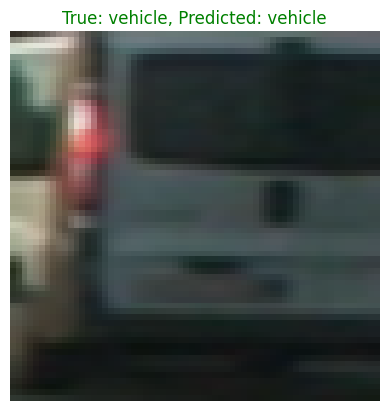

predicted_label non-vehicle


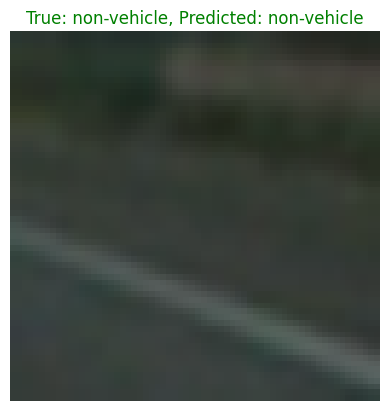

predicted_label vehicle


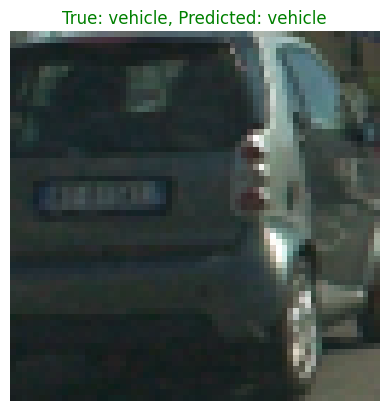

predicted_label vehicle


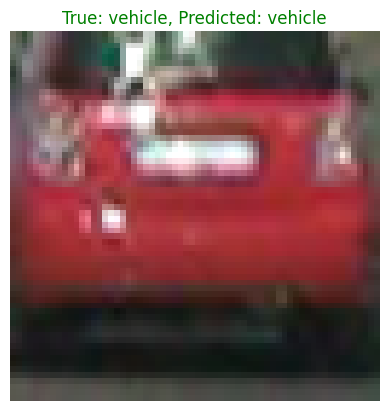

predicted_label non-vehicle


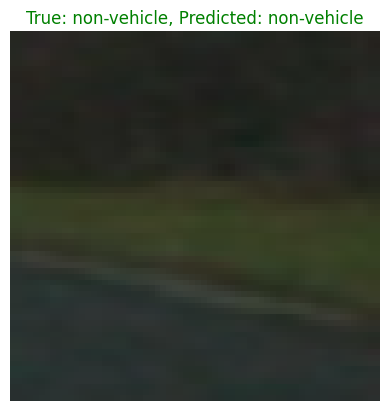

In [37]:
class_labels = {0: 'non-vehicle', 1: 'vehicle'}
print(type(class_labels))

# Function to display images with predictions
def visualize_predictions(model, test_data_gen, num_samples=5):
    print("test_data_gen",test_data_gen)
    # Generate predictions for the test set
    predictions = model.predict(test_data_gen)

    # Get the true labels from the test set
    true_labels = test_data_gen.classes
    print('true_labels',true_labels)

    # Get the class indices (0 or 1)
    class_indices = test_data_gen.class_indices
    print
#     # Get the class labels ('non-vehicle' or 'vehicle')
    # class_labels = {v: k for k, v in class_indices.items()}

    filenames = test_data_gen.filenames
    
    # Select a random sample of test images
    sample_indices = np.random.choice(len(filenames), num_samples, replace=False)

    # Display the images with predictions
    for i in sample_indices:
        filename = filenames[i]

        # Get the true label
        true_label = class_labels[true_labels[i]]

        # Get the predicted probability and class
        predicted_prob = predictions[i]
        predicted_class = int(predicted_prob > 0.5)
        
        predicted_label = class_labels[predicted_class]
        print("predicted_label",predicted_label)

        # Determine the color for the label (green for correct, red for incorrect)
        label_color = 'green' if true_label == predicted_label else 'red'

        # Load and display the image
        img_path = os.path.join('data/test/', filename)
        img = plt.imread(img_path)

        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}', color=label_color)
        plt.axis('off')
        plt.show()

visualize_predictions(model, test_Image, num_samples=5)


In [16]:
print("\nClassification Report:")
score, acc, pre, rcl = model.evaluate(test_Image)
print('Test Loss:', score * 100)
print('Test Accuracy:' ,acc * 100)
print('Test Precision:',pre * 100)
print('Test Recall:', rcl * 100)
f1_score=2 * (pre * rcl) / (rcl + rcl)
print('Test F1-Score:' ,f1_score * 100)


Classification Report:
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.9850 - loss: 0.0988 - precision_1: 0.4676 - recall_1: 0.5026
Test Loss: 8.975965529680252
Test Accuracy: 98.7334668636322
Test Precision: 97.93064594268799
Test Recall: 99.54519867897034
Test F1-Score: 97.93064594268799


112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step


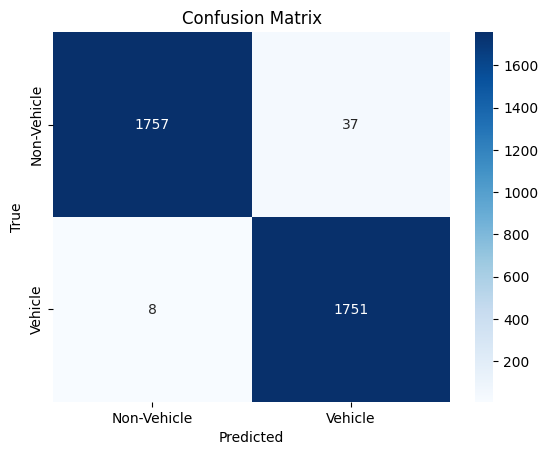

In [17]:
# Generate predictions for the test set using the evaluation generator
predictions = model.predict(test_Image)

# Convert probabilities to binary predictions
binary_predictions = np.round(predictions)

# Get true labels
true_labels = test_Image.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Vehicle', 'Vehicle'], yticklabels=['Non-Vehicle', 'Vehicle'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

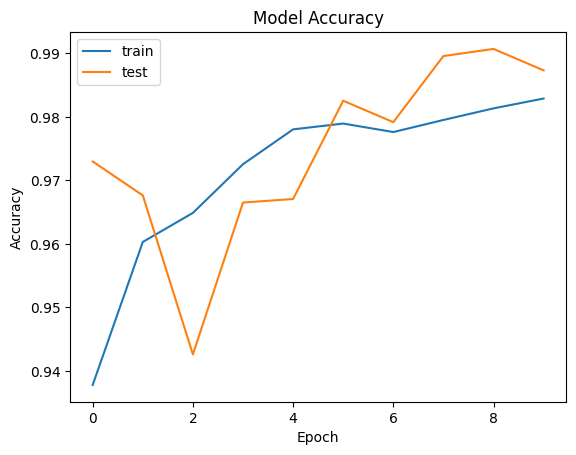

In [18]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in Evaluate2.history :
    k = 'accuracy'

if 'acc' in Evaluate2.history :
    k = 'acc'

if k != '' :
    plt.plot(Evaluate2.history[k])
    plt.plot(Evaluate2.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()





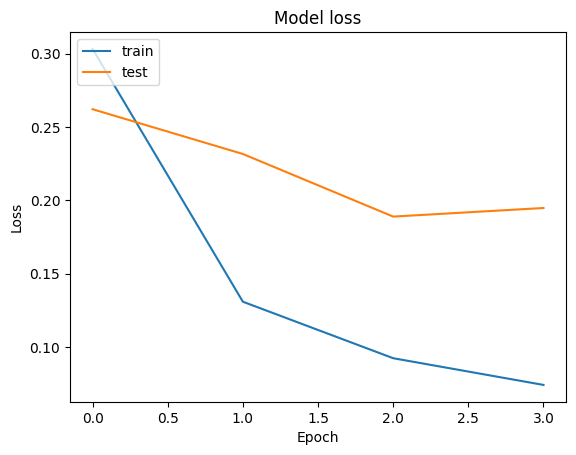

In [19]:
plt.plot(Evaluate1.history['loss'])
plt.plot(Evaluate1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)